In [1]:
# the notebook assumes `jupyter notebook` is run in the directory MHLibDemo.
using IJulia; installkernel("Julia (project=.)", "--project=.")

[ Info: Installing 'Julia (project=.) 1.11.7' kernelspec in /home/mainuser/.local/share/jupyter/kernels/julia-_project_._-1.11


"/home/mainuser/.local/share/jupyter/kernels/julia-_project_._-1.11"

# Demonstration of `MHLib` on the MaxSAT problem
### The subpackage `MHLibDemo` is used.

In [2]:
include("src/MAXSAT.jl")
datapath = joinpath(@__DIR__, "data")

"/home/mainuser/Downloads/002_Teaching/heuopt_LOCALMY/experim/MHLib.jl/MHLibDemos/data"

In [3]:
inst = MAXSATInstance(joinpath(datapath, "maxsat-adv2.cnf"));

In [4]:
sol = MAXSATSolution(inst)

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
sol.obj_val = calc_objective(sol) # Not yet relying on a sophisticated construction heuristic

923

# Crafting a GRASP

We want something more greedy-like, thus we will now modify it towards a routine relying on a restricted candidate list.

In [6]:
function greedy_randomized_construction_heur(inst::MAXSATInstance; alpha::Float64=0.2)
    # implemented almost as on the lecture slides concerning GRASP for MAXSAT
    # (as an exercise, spot the two slight differences!)

    sol::MAXSATSolution = MAXSATSolution(inst)
    clause_sat = falses(inst.m)

    unassigned = collect(1:inst.n) # track unassigned propositional variables

    sol.obj_val = 0

    while !isempty(unassigned)
        
        cand = Tuple{Int,Bool,Int}[] # build list of (var,val,gain)
        for v in unassigned
            for z in (false, true)
                gain = 0
                
                for j in inst.variable_usage[v] # scan through each clause containing v
                    if !clause_sat[j] # skip clauses already satisfied
                        for lit in inst.clauses[j] # check if literal v or ¬v appears
                            if (z && lit == v) || (!z && lit == -v)
                                gain += 1
                                break
                            end
                        end
                    end
                end
                push!(cand, (v, z, gain))
            end
        end

        gains = getindex.(cand, 3)
        g_max, g_min = maximum(gains), minimum(gains)
        thresh = g_max - alpha * (g_max - g_min) # determine threshold

        rcl = filter(c -> c[3] >= thresh, cand)

        v_sel, z_sel, cand = rand(rcl) # select one candidate at random
            
        sol.obj_val += cand # take into account the actual gain which this candidate brings  

        sol.x[v_sel] = z_sel # fix assignment

        # update clause satisfaction
        for j in inst.variable_usage[v_sel]
            if !clause_sat[j]
                # if this literal satisfies clause j, mark it
                for lit in inst.clauses[j]
                    if (z_sel && lit == v_sel) || (!z_sel && lit == -v_sel)
                        clause_sat[j] = true
                        break
                    end
                end
            end
        end

        deleteat!(unassigned, findfirst(==(v_sel), unassigned)) # remove v_sel from unassigned

    end

    sol.obj_val_valid = true
    
    return sol
end

greedy_randomized_construction_heur (generic function with 1 method)

In [7]:
function localimprove!(s::MAXSATSolution, par::Tuple{Int, Bool}) # similar to local_improve! from MHLib
    k, bestimprovement = par[1], par[2]
    k_flip_neighborhood_search!(s, k, bestimprovement) # shipped by MHLib
end

localimprove! (generic function with 1 method)

In [8]:
function LS!(s::MAXSATSolution, par::Tuple{Int, Bool}) # Local Search
    s_prev::MAXSATSolution = copy(s)
    while(true)
        localimprove!(s, par)
        if s.obj_val <= s_prev.obj_val # use a strict stopping criterion: applies when no improvement occurs
            s = copy(s_prev)
            break
        else
            s_prev = copy(s)
        end
    end
end

LS! (generic function with 1 method)

In [9]:
function grasp( inst::MAXSATInstance;
                alpha::Float64 = 0.2,
                k::Int = 1,
                best_improvement::Bool = true,
                number_iter::Int=1000)
    
    best_sol__so_far::MAXSATSolution = MAXSATSolution(inst)

    for i in 1:number_iter
        sol::MAXSATSolution = greedy_randomized_construction_heur(inst; alpha)        
        LS!(sol, (k, best_improvement))
        if best_sol__so_far.obj_val < sol.obj_val
            best_sol__so_far = copy(sol)
        end
    end
    return best_sol__so_far.obj_val
end

grasp (generic function with 1 method)

In [10]:
using CPUTime

In [11]:
CPUtic() # start timer
result = grasp(inst; alpha=0.9999, k=2) # i.e., using the solution construction provided by MHLib
elapsed_secs = CPUtoc() # stop timer
println("Result = $result")

elapsed CPU time: 13.496167 seconds
Result = 984


In [12]:
using Random
using DataFrames, CategoricalArrays, StatsPlots

# A ready-to-use GVNS from MHLib

In [13]:
gvns = GVNS(sol, [MHMethod("con", construct!)],
                 [MHMethod("li1", local_improve!, 1)],
                 
                 #=
                 [ MHMethod("sh1", shaking!, 1),
                   MHMethod("sh2", shaking!, 2),
                   MHMethod("sh3", shaking!, 3),
                   MHMethod("sh4", shaking!, 4)
                 ];
                 =#
                 [MHMethod("sh1", shaking!, 1)];
                 titer=10000);

In [14]:
run!(gvns)

I          1        927.00000        923.00000        927.00000      0.5523                 con 
I          2        931.00000        927.00000        931.00000      1.0041                 li1 
I          3        933.00000        931.00000        933.00000      1.0042                 li1 
I          4        935.00000        933.00000        935.00000      1.0043                 li1 
I          5        936.00000        935.00000        936.00000      1.0043                 li1 
I          6        939.00000        936.00000        939.00000      1.0043                 li1 
I          7        941.00000        939.00000        941.00000      1.0044                 li1 
I          8        943.00000        941.00000        943.00000      1.0044                 li1 
I          9        944.00000        943.00000        944.00000      1.0044                 li1 
I         10        948.00000        944.00000        948.00000      1.0044                 li1 
I         11        950.00000 

In [15]:
method_statistics(gvns.scheduler)


Method statistics
S  method    iter  succ  succ-rate%  tot-obj-gain  avg-obj-gain  rel-succ%  net-time  net-time%  brut-time  brut-time%
S  sh1       3277    14     0.42722     129.00000       0.03937    0.40474   0.21006   11.93100    0.74758    42.46015
S  li1       6722  3444    51.23475    5516.00000       0.82059   99.56635   0.38492   21.86210    0.38492    21.86210
S  con          1     1   100.00000       4.00000       4.00000    0.02891   0.04127    2.34383    0.04127     2.34383
S  SUM/AVG  10000  3459    34.59000    5649.00000       0.56490   33.33333   0.63625   36.13693    1.17376    66.66608



In [16]:
main_results(gvns.scheduler)

T best solution: Bool[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]

T best obj: 1056
T best iteration: 1551
T total iterations: 10000
T best time [s]: 1.298
T total time [s]: 1.7607


In [17]:
sol.obj_val

1056

# Comparison

In [18]:
function gvns_wrapper(inst; number_iter::Int=10000)
    sol = MAXSATSolution(inst)
    gvns = GVNS(sol, [MHMethod("con", construct!)],
                 [MHMethod("li1", local_improve!, 1)],
                 [MHMethod("sh1", shaking!, 1), MHMethod("sh2", shaking!, 2), MHMethod("sh3", shaking!, 3)];
                 titer=number_iter)
    run!(gvns)
    return sol.obj_val
end

function gvns2_wrapper(inst; number_iter::Int=10000)
    sol = MAXSATSolution(inst)
    gvns = GVNS(sol, [MHMethod("con", construct!)],
                 [MHMethod("li1", local_improve!, 1)],
                 [MHMethod("sh1", shaking!, 1)];
                 titer=number_iter)
    run!(gvns)
    return sol.obj_val
end

gvns2_wrapper (generic function with 1 method)

In [19]:
inst_filenames = ["maxsat-adv1.cnf", "maxsat-adv2.cnf"]

instances = [MAXSATInstance(joinpath(datapath, el)) for el in inst_filenames]
reps = 30

30

In [20]:
CPUtic() # start timer
result = grasp(inst; alpha = 0.1, k=1, number_iter=100)
elapsed_secs = CPUtoc() # stop timer
println("Result = $result")

elapsed CPU time: 0.494868 seconds
Result = 1050


In [21]:
CPUtic() # start timer
result = gvns_wrapper(inst; number_iter=10000)
elapsed_secs = CPUtoc() # stop timer
println("Result = $result")

I          1        939.00000        921.00000        939.00000      0.0001                 con 
I          2        943.00000        939.00000        943.00000      0.0002                 li1 
I          3        945.00000        943.00000        945.00000      0.0002                 li1 
I          4        947.00000        945.00000        947.00000      0.0002                 li1 
I          5        950.00000        947.00000        950.00000      0.0003                 li1 
I          6        953.00000        950.00000        953.00000      0.0003                 li1 
I          7        954.00000        953.00000        954.00000      0.0003                 li1 
I          8        956.00000        954.00000        956.00000      0.0003                 li1 
I          9        959.00000        956.00000        959.00000      0.0004                 li1 
I         10        960.00000        959.00000        960.00000      0.0004                 li1 
I         11        961.00000 

I       3304       1060.00000       1059.00000       1060.00000      0.1663                 li1 
I      10000       1060.00000       1060.00000       1059.00000      0.5054                 sh1 
elapsed CPU time: 0.535091 seconds
Result = 1060


In [22]:
# storage
grasp_scores = Dict(inst => Float64[] for inst in instances)
gvns_scores  = Dict(inst => Float64[] for inst in instances)
gvns2_scores = Dict(inst => Float64[] for inst in instances)


Random.seed!(42)

# Experimental Loop
for inst in instances
    for _ in 1:reps
        push!(grasp_scores[inst], grasp(inst; alpha = 0.1, k=1, number_iter=100))
        push!(gvns_scores[inst], gvns_wrapper(inst; number_iter=10000))
        push!(gvns2_scores[inst], gvns_wrapper(inst; number_iter=10000))
    end
end

I          1        714.00000        706.00000        714.00000      0.0001                 con 
I          2        715.00000        714.00000        715.00000      0.0002                 li1 
I          3        717.00000        715.00000        717.00000      0.0002                 li1 
I          4        723.00000        717.00000        723.00000      0.0002                 li1 
I          5        724.00000        723.00000        724.00000      0.0002                 li1 
I          6        727.00000        724.00000        727.00000      0.0003                 li1 
I          7        728.00000        727.00000        728.00000      0.0003                 li1 
I          8        730.00000        728.00000        730.00000      0.0003                 li1 
I          9        731.00000        730.00000        731.00000      0.0004                 li1 
I         10        733.00000        731.00000        733.00000      0.0004                 li1 
I         11        734.00000 

I      10000        767.00000        767.00000        767.00000      0.3106                 li1 
I          1        702.00000        763.00000        702.00000      0.0000                 con 
I          2        705.00000        702.00000        705.00000      0.0000                 li1 
I          3        706.00000        705.00000        706.00000      0.0001                 li1 
I          4        711.00000        706.00000        711.00000      0.0001                 li1 
I          5        714.00000        711.00000        714.00000      0.0001                 li1 
I          6        716.00000        714.00000        716.00000      0.0001                 li1 
I          7        720.00000        716.00000        720.00000      0.0002                 li1 
I          8        723.00000        720.00000        723.00000      0.0002                 li1 
I          9        727.00000        723.00000        727.00000      0.0002                 li1 
I         10        732.00000 

I      10000        766.00000        757.00000        759.00000      0.3117                 li1 
I          1        689.00000        713.00000        689.00000      0.0002                 con 
I          2        693.00000        689.00000        693.00000      0.0003                 li1 
I          3        695.00000        693.00000        695.00000      0.0003                 li1 
I          4        697.00000        695.00000        697.00000      0.0003                 li1 
I          5        698.00000        697.00000        698.00000      0.0003                 li1 
I          6        703.00000        698.00000        703.00000      0.0004                 li1 
I          7        705.00000        703.00000        705.00000      0.0004                 li1 
I          8        706.00000        705.00000        706.00000      0.0004                 li1 
I          9        707.00000        706.00000        707.00000      0.0004                 li1 
I         10        715.00000 

I      10000        763.00000        763.00000        753.00000      0.3309                 sh3 
I          1        683.00000        767.00000        683.00000      0.0000                 con 
I          2        688.00000        683.00000        688.00000      0.0001                 li1 
I          3        694.00000        688.00000        694.00000      0.0001                 li1 
I          4        698.00000        694.00000        698.00000      0.0001                 li1 
I          5        702.00000        698.00000        702.00000      0.0001                 li1 
I          6        703.00000        702.00000        703.00000      0.0002                 li1 
I          7        707.00000        703.00000        707.00000      0.0002                 li1 
I          8        709.00000        707.00000        709.00000      0.0002                 li1 
I          9        715.00000        709.00000        715.00000      0.0003                 li1 
I         10        717.00000 

I      10000        763.00000        763.00000        760.00000      0.3509                 sh1 
I          1        684.00000        708.00000        684.00000      0.0000                 con 
I          2        686.00000        684.00000        686.00000      0.0001                 li1 
I          3        687.00000        686.00000        687.00000      0.0001                 li1 
I          4        688.00000        687.00000        688.00000      0.0001                 li1 
I          5        689.00000        688.00000        689.00000      0.0001                 li1 
I          6        691.00000        689.00000        691.00000      0.0002                 li1 
I          7        693.00000        691.00000        693.00000      0.0002                 li1 
I          8        698.00000        693.00000        698.00000      0.0002                 li1 
I          9        703.00000        698.00000        703.00000      0.0002                 li1 
I         10        706.00000 

I      10000        769.00000        757.00000        758.00000      0.3263                 li1 
I          1        700.00000        701.00000        700.00000      0.0002                 con 
I          2        701.00000        700.00000        701.00000      0.0003                 li1 
I          3        703.00000        701.00000        703.00000      0.0003                 li1 
I          4        706.00000        703.00000        706.00000      0.0003                 li1 
I          5        707.00000        706.00000        707.00000      0.0004                 li1 
I          6        709.00000        707.00000        709.00000      0.0004                 li1 
I          7        710.00000        709.00000        710.00000      0.0004                 li1 
I          8        711.00000        710.00000        711.00000      0.0004                 li1 
I          9        713.00000        711.00000        713.00000      0.0004                 li1 
I         10        714.00000 

I      10000        767.00000        765.00000        767.00000      0.3133                 li1 
I          1        699.00000        767.00000        699.00000      0.0000                 con 
I          2        704.00000        699.00000        704.00000      0.0000                 li1 
I          3        705.00000        704.00000        705.00000      0.0001                 li1 
I          4        706.00000        705.00000        706.00000      0.0001                 li1 
I          5        708.00000        706.00000        708.00000      0.0001                 li1 
I          6        716.00000        708.00000        716.00000      0.0001                 li1 
I          7        717.00000        716.00000        717.00000      0.0002                 li1 
I          8        718.00000        717.00000        718.00000      0.0002                 li1 
I          9        719.00000        718.00000        719.00000      0.0002                 li1 
I         10        722.00000 

I      10000        767.00000        761.00000        763.00000      0.3098                 li1 
I          1        714.00000        698.00000        714.00000      0.0002                 con 
I          2        716.00000        714.00000        716.00000      0.0003                 li1 
I          3        717.00000        716.00000        717.00000      0.0003                 li1 
I          4        719.00000        717.00000        719.00000      0.0003                 li1 
I          5        720.00000        719.00000        720.00000      0.0003                 li1 
I          6        721.00000        720.00000        721.00000      0.0004                 li1 
I          7        722.00000        721.00000        722.00000      0.0004                 li1 
I          8        725.00000        722.00000        725.00000      0.0004                 li1 
I          9        726.00000        725.00000        726.00000      0.0004                 li1 
I         10        729.00000 

I      10000        767.00000        767.00000        766.00000      0.3142                 sh1 
I          1        691.00000        760.00000        691.00000      0.0000                 con 
I          2        694.00000        691.00000        694.00000      0.0001                 li1 
I          3        697.00000        694.00000        697.00000      0.0001                 li1 
I          4        698.00000        697.00000        698.00000      0.0001                 li1 
I          5        706.00000        698.00000        706.00000      0.0001                 li1 
I          6        708.00000        706.00000        708.00000      0.0002                 li1 
I          7        714.00000        708.00000        714.00000      0.0002                 li1 
I          8        715.00000        714.00000        715.00000      0.0002                 li1 
I          9        716.00000        715.00000        716.00000      0.0002                 li1 
I         10        719.00000 

I       5930        765.00000        764.00000        765.00000      0.1860                 li1 
I       5931        766.00000        765.00000        766.00000      0.1861                 li1 
I      10000        766.00000        761.00000        766.00000      0.3149                 li1 
I          1        715.00000        706.00000        715.00000      0.0002                 con 
I          2        718.00000        715.00000        718.00000      0.0003                 li1 
I          3        721.00000        718.00000        721.00000      0.0003                 li1 
I          4        725.00000        721.00000        725.00000      0.0003                 li1 
I          5        728.00000        725.00000        728.00000      0.0003                 li1 
I          6        734.00000        728.00000        734.00000      0.0004                 li1 
I          7        736.00000        734.00000        736.00000      0.0004                 li1 
I          8        738.00000 

I       4737        767.00000        766.00000        767.00000      0.1551                 li1 
I      10000        767.00000        765.00000        767.00000      0.3262                 li1 
I          1        699.00000        703.00000        699.00000      0.0000                 con 
I          2        701.00000        699.00000        701.00000      0.0001                 li1 
I          3        705.00000        701.00000        705.00000      0.0001                 li1 
I          4        707.00000        705.00000        707.00000      0.0001                 li1 
I          5        711.00000        707.00000        711.00000      0.0001                 li1 
I          6        715.00000        711.00000        715.00000      0.0001                 li1 
I          7        718.00000        715.00000        718.00000      0.0002                 li1 
I          8        719.00000        718.00000        719.00000      0.0002                 li1 
I          9        721.00000 

I      10000        764.00000        760.00000        764.00000      0.3123                 li1 
I          1        714.00000        702.00000        714.00000      0.0002                 con 
I          2        718.00000        714.00000        718.00000      0.0003                 li1 
I          3        719.00000        718.00000        719.00000      0.0003                 li1 
I          4        721.00000        719.00000        721.00000      0.0003                 li1 
I          5        723.00000        721.00000        723.00000      0.0004                 li1 
I          6        724.00000        723.00000        724.00000      0.0004                 li1 
I          7        727.00000        724.00000        727.00000      0.0004                 li1 
I          8        728.00000        727.00000        728.00000      0.0004                 li1 
I          9        730.00000        728.00000        730.00000      0.0005                 li1 
I         10        731.00000 

I      10000        766.00000        763.00000        766.00000      0.3195                 li1 
I          1        699.00000        695.00000        699.00000      0.0000                 con 
I          2        702.00000        699.00000        702.00000      0.0000                 li1 
I          3        703.00000        702.00000        703.00000      0.0001                 li1 
I          4        709.00000        703.00000        709.00000      0.0001                 li1 
I          5        711.00000        709.00000        711.00000      0.0001                 li1 
I          6        714.00000        711.00000        714.00000      0.0001                 li1 
I          7        717.00000        714.00000        717.00000      0.0002                 li1 
I          8        719.00000        717.00000        719.00000      0.0002                 li1 
I          9        722.00000        719.00000        722.00000      0.0002                 li1 
I         10        723.00000 

I      10000        764.00000        753.00000        754.00000      0.3133                 li1 
I          1        705.00000        704.00000        705.00000      0.0002                 con 
I          2        707.00000        705.00000        707.00000      0.0003                 li1 
I          3        708.00000        707.00000        708.00000      0.0003                 li1 
I          4        710.00000        708.00000        710.00000      0.0003                 li1 
I          5        712.00000        710.00000        712.00000      0.0004                 li1 
I          6        714.00000        712.00000        714.00000      0.0004                 li1 
I          7        717.00000        714.00000        717.00000      0.0004                 li1 
I          8        718.00000        717.00000        718.00000      0.0005                 li1 
I          9        719.00000        718.00000        719.00000      0.0005                 li1 
I         10        721.00000 

I      10000        769.00000        762.00000        763.00000      0.3145                 li1 
I          1        715.00000        707.00000        715.00000      0.0000                 con 
I          2        718.00000        715.00000        718.00000      0.0000                 li1 
I          3        723.00000        718.00000        723.00000      0.0001                 li1 
I          4        725.00000        723.00000        725.00000      0.0001                 li1 
I          5        727.00000        725.00000        727.00000      0.0001                 li1 
I          6        729.00000        727.00000        729.00000      0.0002                 li1 
I          7        731.00000        729.00000        731.00000      0.0002                 li1 
I          8        733.00000        731.00000        733.00000      0.0002                 li1 
I          9        734.00000        733.00000        734.00000      0.0002                 li1 
I         10        737.00000 

I      10000        766.00000        764.00000        766.00000      0.3133                 li1 
I          1        700.00000        766.00000        700.00000      0.0002                 con 
I          2        704.00000        700.00000        704.00000      0.0003                 li1 
I          3        708.00000        704.00000        708.00000      0.0003                 li1 
I          4        709.00000        708.00000        709.00000      0.0003                 li1 
I          5        712.00000        709.00000        712.00000      0.0004                 li1 
I          6        713.00000        712.00000        713.00000      0.0004                 li1 
I          7        715.00000        713.00000        715.00000      0.0004                 li1 
I          8        717.00000        715.00000        717.00000      0.0004                 li1 
I          9        720.00000        717.00000        720.00000      0.0005                 li1 
I         10        722.00000 

I      10000        765.00000        763.00000        765.00000      0.3156                 li1 
I          1        693.00000        750.00000        693.00000      0.0000                 con 
I          2        696.00000        693.00000        696.00000      0.0000                 li1 
I          3        701.00000        696.00000        701.00000      0.0001                 li1 
I          4        705.00000        701.00000        705.00000      0.0001                 li1 
I          5        707.00000        705.00000        707.00000      0.0001                 li1 
I          6        709.00000        707.00000        709.00000      0.0001                 li1 
I          7        710.00000        709.00000        710.00000      0.0002                 li1 
I          8        712.00000        710.00000        712.00000      0.0002                 li1 
I          9        713.00000        712.00000        713.00000      0.0002                 li1 
I         10        714.00000 

I      10000        767.00000        764.00000        765.00000      0.3152                 li1 
I          1        690.00000        699.00000        690.00000      0.0002                 con 
I          2        693.00000        690.00000        693.00000      0.0002                 li1 
I          3        695.00000        693.00000        695.00000      0.0003                 li1 
I          4        699.00000        695.00000        699.00000      0.0003                 li1 
I          5        700.00000        699.00000        700.00000      0.0003                 li1 
I          6        702.00000        700.00000        702.00000      0.0003                 li1 
I          7        703.00000        702.00000        703.00000      0.0004                 li1 
I          8        706.00000        703.00000        706.00000      0.0004                 li1 
I          9        709.00000        706.00000        709.00000      0.0004                 li1 
I         10        711.00000 

I      10000        767.00000        766.00000        767.00000      0.3160                 li1 
I          1        686.00000        704.00000        686.00000      0.0002                 con 
I          2        687.00000        686.00000        687.00000      0.0003                 li1 
I          3        693.00000        687.00000        693.00000      0.0003                 li1 
I          4        695.00000        693.00000        695.00000      0.0003                 li1 
I          5        697.00000        695.00000        697.00000      0.0004                 li1 
I          6        699.00000        697.00000        699.00000      0.0004                 li1 
I          7        700.00000        699.00000        700.00000      0.0004                 li1 
I          8        704.00000        700.00000        704.00000      0.0005                 li1 
I          9        708.00000        704.00000        708.00000      0.0005                 li1 
I         10        709.00000 

I      10000        764.00000        761.00000        764.00000      0.3139                 li1 
I          1        700.00000        706.00000        700.00000      0.0002                 con 
I          2        703.00000        700.00000        703.00000      0.0003                 li1 
I          3        704.00000        703.00000        704.00000      0.0003                 li1 
I          4        705.00000        704.00000        705.00000      0.0003                 li1 
I          5        706.00000        705.00000        706.00000      0.0004                 li1 
I          6        708.00000        706.00000        708.00000      0.0004                 li1 
I          7        710.00000        708.00000        710.00000      0.0004                 li1 
I          8        711.00000        710.00000        711.00000      0.0005                 li1 
I          9        712.00000        711.00000        712.00000      0.0005                 li1 
I         10        714.00000 

I      10000        764.00000        755.00000        757.00000      0.3116                 li1 
I          1        699.00000        706.00000        699.00000      0.0000                 con 
I          2        700.00000        699.00000        700.00000      0.0000                 li1 
I          3        702.00000        700.00000        702.00000      0.0001                 li1 
I          4        707.00000        702.00000        707.00000      0.0001                 li1 
I          5        710.00000        707.00000        710.00000      0.0001                 li1 
I          6        714.00000        710.00000        714.00000      0.0001                 li1 
I          7        716.00000        714.00000        716.00000      0.0002                 li1 
I          8        721.00000        716.00000        721.00000      0.0002                 li1 
I          9        723.00000        721.00000        723.00000      0.0002                 li1 
I         10        724.00000 

I       7173        763.00000        762.00000        763.00000      0.2214                 li1 
I       7187        765.00000        762.00000        765.00000      0.2219                 li1 
I      10000        765.00000        765.00000        761.00000      0.3116                 sh2 
I          1        911.00000       1043.00000        911.00000      0.0002                 con 
I          2        912.00000        911.00000        912.00000      0.0003                 li1 
I          3        914.00000        912.00000        914.00000      0.0003                 li1 
I          4        915.00000        914.00000        915.00000      0.0003                 li1 
I          5        917.00000        915.00000        917.00000      0.0004                 li1 
I          6        918.00000        917.00000        918.00000      0.0004                 li1 
I          7        919.00000        918.00000        919.00000      0.0004                 li1 
I          8        920.00000 

I       4838       1058.00000       1057.00000       1058.00000      0.2355                 li1 
I       4865       1059.00000       1058.00000       1059.00000      0.2371                 li1 
I       5937       1060.00000       1058.00000       1060.00000      0.2889                 li1 
I      10000       1060.00000       1060.00000       1060.00000      0.4895                 li1 
I          1        934.00000       1055.00000        934.00000      0.0000                 con 
I          2        935.00000        934.00000        935.00000      0.0001                 li1 
I          3        938.00000        935.00000        938.00000      0.0001                 li1 
I          4        939.00000        938.00000        939.00000      0.0001                 li1 
I          5        943.00000        939.00000        943.00000      0.0001                 li1 
I          6        946.00000        943.00000        946.00000      0.0001                 li1 
I          7        948.00000 

I        538       1061.00000       1060.00000       1061.00000      0.0257                 li1 
I      10000       1061.00000       1058.00000       1059.00000      0.4826                 li1 
I          1        926.00000        925.00000        926.00000      0.0002                 con 
I          2        929.00000        926.00000        929.00000      0.0003                 li1 
I          3        930.00000        929.00000        930.00000      0.0003                 li1 
I          4        932.00000        930.00000        932.00000      0.0003                 li1 
I          5        933.00000        932.00000        933.00000      0.0004                 li1 
I          6        935.00000        933.00000        935.00000      0.0004                 li1 
I          7        937.00000        935.00000        937.00000      0.0004                 li1 
I          8        938.00000        937.00000        938.00000      0.0004                 li1 
I          9        941.00000 

I      10000       1062.00000       1062.00000       1062.00000      0.4829                 li1 
I          1        923.00000        927.00000        923.00000      0.0000                 con 
I          2        924.00000        923.00000        924.00000      0.0001                 li1 
I          3        927.00000        924.00000        927.00000      0.0001                 li1 
I          4        930.00000        927.00000        930.00000      0.0001                 li1 
I          5        931.00000        930.00000        931.00000      0.0001                 li1 
I          6        932.00000        931.00000        932.00000      0.0001                 li1 
I          7        934.00000        932.00000        934.00000      0.0002                 li1 
I          8        940.00000        934.00000        940.00000      0.0002                 li1 
I          9        941.00000        940.00000        941.00000      0.0002                 li1 
I         10        944.00000 

I        439       1050.00000       1049.00000       1050.00000      0.0218                 li1 
I        480       1051.00000       1050.00000       1051.00000      0.0239                 li1 
I        599       1052.00000       1051.00000       1052.00000      0.0298                 li1 
I        642       1053.00000       1052.00000       1053.00000      0.0321                 li1 
I        676       1054.00000       1053.00000       1054.00000      0.0339                 li1 
I        801       1055.00000       1053.00000       1055.00000      0.0401                 li1 
I        849       1056.00000       1052.00000       1056.00000      0.0427                 li1 
I        873       1057.00000       1056.00000       1057.00000      0.0439                 li1 
I      10000       1057.00000       1054.00000       1056.00000      0.5044                 li1 
I          1        924.00000        923.00000        924.00000      0.0002                 con 
I          2        926.00000 

I      10000       1059.00000       1058.00000       1059.00000      0.4882                 li1 
I          1        941.00000       1059.00000        941.00000      0.0000                 con 
I          2        942.00000        941.00000        942.00000      0.0001                 li1 
I          3        944.00000        942.00000        944.00000      0.0001                 li1 
I          4        945.00000        944.00000        945.00000      0.0001                 li1 
I          5        946.00000        945.00000        946.00000      0.0001                 li1 
I          6        947.00000        946.00000        947.00000      0.0002                 li1 
I          7        948.00000        947.00000        948.00000      0.0002                 li1 
I          8        950.00000        948.00000        950.00000      0.0002                 li1 
I          9        951.00000        950.00000        951.00000      0.0002                 li1 
I         10        952.00000 

I        263       1051.00000       1050.00000       1051.00000      0.0119                 li1 
I        264       1052.00000       1051.00000       1052.00000      0.0119                 li1 
I        293       1053.00000       1052.00000       1053.00000      0.0135                 li1 
I       1605       1054.00000       1053.00000       1054.00000      0.0783                 li1 
I       1805       1055.00000       1052.00000       1055.00000      0.0883                 li1 
I      10000       1055.00000       1050.00000       1052.00000      0.5053                 li1 
I          1        927.00000        924.00000        927.00000      0.0002                 con 
I          2        929.00000        927.00000        929.00000      0.0003                 li1 
I          3        932.00000        929.00000        932.00000      0.0003                 li1 
I          4        933.00000        932.00000        933.00000      0.0003                 li1 
I          5        935.00000 

I      10000       1056.00000       1056.00000       1053.00000      0.4927                 sh3 
I          1        936.00000       1056.00000        936.00000      0.0000                 con 
I          2        937.00000        936.00000        937.00000      0.0001                 li1 
I          3        939.00000        937.00000        939.00000      0.0001                 li1 
I          4        940.00000        939.00000        940.00000      0.0001                 li1 
I          5        942.00000        940.00000        942.00000      0.0001                 li1 
I          6        943.00000        942.00000        943.00000      0.0001                 li1 
I          7        944.00000        943.00000        944.00000      0.0002                 li1 
I          8        946.00000        944.00000        946.00000      0.0002                 li1 
I          9        949.00000        946.00000        949.00000      0.0002                 li1 
I         10        950.00000 

I      10000       1061.00000       1061.00000       1055.00000      0.4868                 sh2 
I          1        931.00000        924.00000        931.00000      0.0002                 con 
I          2        934.00000        931.00000        934.00000      0.0003                 li1 
I          3        935.00000        934.00000        935.00000      0.0003                 li1 
I          4        937.00000        935.00000        937.00000      0.0004                 li1 
I          5        940.00000        937.00000        940.00000      0.0004                 li1 
I          6        942.00000        940.00000        942.00000      0.0004                 li1 
I          7        943.00000        942.00000        943.00000      0.0004                 li1 
I          8        944.00000        943.00000        944.00000      0.0005                 li1 
I          9        946.00000        944.00000        946.00000      0.0005                 li1 
I         10        948.00000 

I       2373       1054.00000       1053.00000       1054.00000      0.1142                 li1 
I       2382       1055.00000       1052.00000       1055.00000      0.1148                 li1 
I       2956       1056.00000       1055.00000       1056.00000      0.1427                 li1 
I       3023       1057.00000       1055.00000       1057.00000      0.1463                 li1 
I       3116       1058.00000       1056.00000       1058.00000      0.1511                 li1 
I       5530       1059.00000       1058.00000       1059.00000      0.2726                 li1 
I      10000       1059.00000       1059.00000       1054.00000      0.4962                 sh2 
I          1        932.00000       1056.00000        932.00000      0.0000                 con 
I          2        933.00000        932.00000        933.00000      0.0001                 li1 
I          3        934.00000        933.00000        934.00000      0.0001                 li1 
I          4        935.00000 

I        104       1047.00000       1046.00000       1047.00000      0.0041                 li1 
I        105       1048.00000       1047.00000       1048.00000      0.0042                 li1 
I        121       1049.00000       1048.00000       1049.00000      0.0051                 li1 
I        188       1050.00000       1049.00000       1050.00000      0.0085                 li1 
I        251       1051.00000       1049.00000       1051.00000      0.0121                 li1 
I        262       1052.00000       1051.00000       1052.00000      0.0128                 li1 
I        263       1053.00000       1052.00000       1053.00000      0.0129                 li1 
I        374       1054.00000       1053.00000       1054.00000      0.0182                 li1 
I        545       1055.00000       1054.00000       1055.00000      0.0269                 li1 
I      10000       1055.00000       1055.00000       1055.00000      0.5034                 li1 
I          1        936.00000 

I       2715       1055.00000       1054.00000       1055.00000      0.1419                 li1 
I      10000       1055.00000       1052.00000       1055.00000      0.5062                 li1 
I          1        923.00000       1053.00000        923.00000      0.0000                 con 
I          2        925.00000        923.00000        925.00000      0.0001                 li1 
I          3        927.00000        925.00000        927.00000      0.0001                 li1 
I          4        928.00000        927.00000        928.00000      0.0001                 li1 
I          5        931.00000        928.00000        931.00000      0.0001                 li1 
I          6        932.00000        931.00000        932.00000      0.0001                 li1 
I          7        935.00000        932.00000        935.00000      0.0002                 li1 
I          8        939.00000        935.00000        939.00000      0.0002                 li1 
I          9        942.00000 

I       3434       1057.00000       1055.00000       1057.00000      0.1654                 li1 
I      10000       1057.00000       1057.00000       1057.00000      0.4858                 sh1 
I          1        952.00000       1042.00000        952.00000      0.0002                 con 
I          2        953.00000        952.00000        953.00000      0.0003                 li1 
I          3        955.00000        953.00000        955.00000      0.0003                 li1 
I          4        956.00000        955.00000        956.00000      0.0004                 li1 
I          5        957.00000        956.00000        957.00000      0.0004                 li1 
I          6        958.00000        957.00000        958.00000      0.0004                 li1 
I          7        961.00000        958.00000        961.00000      0.0004                 li1 
I          8        962.00000        961.00000        962.00000      0.0005                 li1 
I          9        963.00000 

I        143       1048.00000       1047.00000       1048.00000      0.0069                 li1 
I        144       1049.00000       1048.00000       1049.00000      0.0070                 li1 
I        145       1050.00000       1049.00000       1050.00000      0.0071                 li1 
I        198       1051.00000       1050.00000       1051.00000      0.0099                 li1 
I        307       1052.00000       1051.00000       1052.00000      0.0156                 li1 
I        365       1053.00000       1052.00000       1053.00000      0.0185                 li1 
I        384       1054.00000       1053.00000       1054.00000      0.0195                 li1 
I        385       1055.00000       1054.00000       1055.00000      0.0196                 li1 
I        402       1056.00000       1055.00000       1056.00000      0.0205                 li1 
I        403       1057.00000       1056.00000       1057.00000      0.0206                 li1 
I        463       1058.00000 

I      10000       1055.00000       1051.00000       1052.00000      0.4945                 li1 
I          1        941.00000       1051.00000        941.00000      0.0000                 con 
I          2        942.00000        941.00000        942.00000      0.0001                 li1 
I          3        943.00000        942.00000        943.00000      0.0001                 li1 
I          4        946.00000        943.00000        946.00000      0.0001                 li1 
I          5        948.00000        946.00000        948.00000      0.0001                 li1 
I          6        950.00000        948.00000        950.00000      0.0002                 li1 
I          7        951.00000        950.00000        951.00000      0.0002                 li1 
I          8        952.00000        951.00000        952.00000      0.0002                 li1 
I          9        954.00000        952.00000        954.00000      0.0002                 li1 
I         10        955.00000 

I      10000       1055.00000       1055.00000       1055.00000      0.5027                 li1 
I          1        926.00000        921.00000        926.00000      0.0002                 con 
I          2        931.00000        926.00000        931.00000      0.0003                 li1 
I          3        932.00000        931.00000        932.00000      0.0003                 li1 
I          4        933.00000        932.00000        933.00000      0.0003                 li1 
I          5        934.00000        933.00000        934.00000      0.0004                 li1 
I          6        935.00000        934.00000        935.00000      0.0004                 li1 
I          7        942.00000        935.00000        942.00000      0.0004                 li1 
I          8        943.00000        942.00000        943.00000      0.0004                 li1 
I          9        945.00000        943.00000        945.00000      0.0005                 li1 
I         10        946.00000 

I      10000       1057.00000       1057.00000       1057.00000      0.4814                 li1 
I          1        947.00000       1047.00000        947.00000      0.0000                 con 
I          2        952.00000        947.00000        952.00000      0.0001                 li1 
I          3        954.00000        952.00000        954.00000      0.0001                 li1 
I          4        957.00000        954.00000        957.00000      0.0001                 li1 
I          5        958.00000        957.00000        958.00000      0.0001                 li1 
I          6        959.00000        958.00000        959.00000      0.0002                 li1 
I          7        962.00000        959.00000        962.00000      0.0002                 li1 
I          8        967.00000        962.00000        967.00000      0.0002                 li1 
I          9        968.00000        967.00000        968.00000      0.0002                 li1 
I         10        969.00000 

I      10000       1058.00000       1056.00000       1057.00000      0.4952                 li1 
I          1        933.00000        926.00000        933.00000      0.0002                 con 
I          2        934.00000        933.00000        934.00000      0.0003                 li1 
I          3        936.00000        934.00000        936.00000      0.0003                 li1 
I          4        937.00000        936.00000        937.00000      0.0003                 li1 
I          5        938.00000        937.00000        938.00000      0.0003                 li1 
I          6        940.00000        938.00000        940.00000      0.0004                 li1 
I          7        945.00000        940.00000        945.00000      0.0004                 li1 
I          8        947.00000        945.00000        947.00000      0.0004                 li1 
I          9        949.00000        947.00000        949.00000      0.0004                 li1 
I         10        950.00000 

I       6730       1053.00000       1052.00000       1053.00000      0.3333                 li1 
I       8638       1054.00000       1053.00000       1054.00000      0.4338                 li1 
I      10000       1054.00000       1051.00000       1052.00000      0.5014                 li1 
I          1        922.00000       1049.00000        922.00000      0.0000                 con 
I          2        923.00000        922.00000        923.00000      0.0001                 li1 
I          3        924.00000        923.00000        924.00000      0.0001                 li1 
I          4        925.00000        924.00000        925.00000      0.0001                 li1 
I          5        927.00000        925.00000        927.00000      0.0001                 li1 
I          6        929.00000        927.00000        929.00000      0.0001                 li1 
I          7        931.00000        929.00000        931.00000      0.0002                 li1 
I          8        933.00000 

I       2648       1061.00000       1060.00000       1061.00000      0.1324                 li1 
I       3016       1062.00000       1061.00000       1062.00000      0.1533                 li1 
I      10000       1062.00000       1060.00000       1062.00000      0.4983                 li1 
I          1        932.00000       1044.00000        932.00000      0.0002                 con 
I          2        935.00000        932.00000        935.00000      0.0003                 li1 
I          3        937.00000        935.00000        937.00000      0.0003                 li1 
I          4        938.00000        937.00000        938.00000      0.0003                 li1 
I          5        939.00000        938.00000        939.00000      0.0004                 li1 
I          6        940.00000        939.00000        940.00000      0.0004                 li1 
I          7        941.00000        940.00000        941.00000      0.0004                 li1 
I          8        942.00000 

I       7519       1058.00000       1057.00000       1058.00000      0.3632                 li1 
I       7520       1059.00000       1058.00000       1059.00000      0.3634                 li1 
I      10000       1059.00000       1058.00000       1059.00000      0.4807                 li1 
I          1        913.00000        940.00000        913.00000      0.0000                 con 
I          2        914.00000        913.00000        914.00000      0.0001                 li1 
I          3        917.00000        914.00000        917.00000      0.0001                 li1 
I          4        919.00000        917.00000        919.00000      0.0001                 li1 
I          5        920.00000        919.00000        920.00000      0.0001                 li1 
I          6        921.00000        920.00000        921.00000      0.0001                 li1 
I          7        922.00000        921.00000        922.00000      0.0002                 li1 
I          8        925.00000 

I        589       1050.00000       1048.00000       1050.00000      0.0302                 li1 
I        695       1051.00000       1048.00000       1051.00000      0.0357                 li1 
I        720       1052.00000       1051.00000       1052.00000      0.0370                 li1 
I       1133       1053.00000       1052.00000       1053.00000      0.0579                 li1 
I       1201       1055.00000       1053.00000       1055.00000      0.0614                 li1 
I       1242       1056.00000       1055.00000       1056.00000      0.0635                 li1 
I      10000       1056.00000       1056.00000       1056.00000      0.4982                 li1 
I          1        929.00000        923.00000        929.00000      0.0002                 con 
I          2        931.00000        929.00000        931.00000      0.0003                 li1 
I          3        932.00000        931.00000        932.00000      0.0003                 li1 
I          4        933.00000 

I      10000       1052.00000       1052.00000       1049.00000      0.4993                 sh2 
I          1        919.00000       1052.00000        919.00000      0.0000                 con 
I          2        921.00000        919.00000        921.00000      0.0001                 li1 
I          3        923.00000        921.00000        923.00000      0.0001                 li1 
I          4        925.00000        923.00000        925.00000      0.0001                 li1 
I          5        928.00000        925.00000        928.00000      0.0001                 li1 
I          6        931.00000        928.00000        931.00000      0.0002                 li1 
I          7        934.00000        931.00000        934.00000      0.0002                 li1 
I          8        935.00000        934.00000        935.00000      0.0002                 li1 
I          9        936.00000        935.00000        936.00000      0.0002                 li1 
I         10        939.00000 

I      10000       1058.00000       1057.00000       1058.00000      0.5011                 li1 
I          1        921.00000        926.00000        921.00000      0.0002                 con 
I          2        922.00000        921.00000        922.00000      0.0003                 li1 
I          3        923.00000        922.00000        923.00000      0.0003                 li1 
I          4        924.00000        923.00000        924.00000      0.0003                 li1 
I          5        926.00000        924.00000        926.00000      0.0004                 li1 
I          6        927.00000        926.00000        927.00000      0.0004                 li1 
I          7        928.00000        927.00000        928.00000      0.0004                 li1 
I          8        929.00000        928.00000        929.00000      0.0005                 li1 
I          9        931.00000        929.00000        931.00000      0.0005                 li1 
I         10        932.00000 

I      10000       1058.00000       1055.00000       1058.00000      0.4815                 li1 
I          1        936.00000       1058.00000        936.00000      0.0000                 con 
I          2        938.00000        936.00000        938.00000      0.0001                 li1 
I          3        940.00000        938.00000        940.00000      0.0001                 li1 
I          4        941.00000        940.00000        941.00000      0.0001                 li1 
I          5        942.00000        941.00000        942.00000      0.0001                 li1 
I          6        943.00000        942.00000        943.00000      0.0001                 li1 
I          7        946.00000        943.00000        946.00000      0.0002                 li1 
I          8        947.00000        946.00000        947.00000      0.0002                 li1 
I          9        948.00000        947.00000        948.00000      0.0002                 li1 
I         10        951.00000 

I       4230       1058.00000       1057.00000       1058.00000      0.2034                 li1 
I      10000       1058.00000       1057.00000       1058.00000      0.4955                 li1 
I          1        929.00000        926.00000        929.00000      0.0002                 con 
I          2        930.00000        929.00000        930.00000      0.0003                 li1 
I          3        931.00000        930.00000        931.00000      0.0003                 li1 
I          4        933.00000        931.00000        933.00000      0.0003                 li1 
I          5        934.00000        933.00000        934.00000      0.0004                 li1 
I          6        935.00000        934.00000        935.00000      0.0004                 li1 
I          7        936.00000        935.00000        936.00000      0.0004                 li1 
I          8        938.00000        936.00000        938.00000      0.0004                 li1 
I          9        939.00000 

I      10000       1055.00000       1055.00000       1052.00000      0.4891                 sh1 
I          1        931.00000       1054.00000        931.00000      0.0000                 con 
I          2        932.00000        931.00000        932.00000      0.0000                 li1 
I          3        935.00000        932.00000        935.00000      0.0001                 li1 
I          4        936.00000        935.00000        936.00000      0.0001                 li1 
I          5        937.00000        936.00000        937.00000      0.0001                 li1 
I          6        939.00000        937.00000        939.00000      0.0001                 li1 
I          7        940.00000        939.00000        940.00000      0.0002                 li1 
I          8        941.00000        940.00000        941.00000      0.0002                 li1 
I          9        942.00000        941.00000        942.00000      0.0002                 li1 
I         10        943.00000 

I        287       1056.00000       1055.00000       1056.00000      0.0138                 li1 
I        412       1057.00000       1056.00000       1057.00000      0.0198                 li1 
I        718       1058.00000       1057.00000       1058.00000      0.0349                 li1 
I       9635       1059.00000       1058.00000       1059.00000      0.4674                 li1 
I       9716       1060.00000       1059.00000       1060.00000      0.4715                 li1 
I      10000       1060.00000       1057.00000       1058.00000      0.4855                 li1 
I          1        938.00000        924.00000        938.00000      0.0002                 con 
I          2        939.00000        938.00000        939.00000      0.0003                 li1 
I          3        942.00000        939.00000        942.00000      0.0003                 li1 
I          4        944.00000        942.00000        944.00000      0.0004                 li1 
I          5        945.00000 

I       2289       1060.00000       1059.00000       1060.00000      0.1133                 li1 
I       7121       1061.00000       1060.00000       1061.00000      0.3485                 li1 
I      10000       1061.00000       1061.00000       1061.00000      0.4911                 li1 
I          1        947.00000       1058.00000        947.00000      0.0000                 con 
I          2        949.00000        947.00000        949.00000      0.0001                 li1 
I          3        950.00000        949.00000        950.00000      0.0001                 li1 
I          4        955.00000        950.00000        955.00000      0.0001                 li1 
I          5        956.00000        955.00000        956.00000      0.0001                 li1 
I          6        957.00000        956.00000        957.00000      0.0001                 li1 
I          7        958.00000        957.00000        958.00000      0.0002                 li1 
I          8        959.00000 

I        192       1052.00000       1051.00000       1052.00000      0.0083                 li1 
I        201       1053.00000       1050.00000       1053.00000      0.0089                 li1 
I        430       1054.00000       1053.00000       1054.00000      0.0202                 li1 
I        661       1055.00000       1054.00000       1055.00000      0.0317                 li1 
I       1072       1056.00000       1055.00000       1056.00000      0.0521                 li1 
I       1096       1057.00000       1056.00000       1057.00000      0.0534                 li1 
I       1626       1058.00000       1057.00000       1058.00000      0.0787                 li1 
I       1945       1059.00000       1058.00000       1059.00000      0.0944                 li1 
I      10000       1059.00000       1056.00000       1057.00000      0.4910                 li1 
I          1        926.00000        929.00000        926.00000      0.0002                 con 
I          2        927.00000 

I       4022       1055.00000       1054.00000       1055.00000      0.1939                 li1 
I       4169       1056.00000       1055.00000       1056.00000      0.2012                 li1 
I       4236       1057.00000       1056.00000       1057.00000      0.2046                 li1 
I       4781       1058.00000       1056.00000       1058.00000      0.2313                 li1 
I       5801       1059.00000       1058.00000       1059.00000      0.2834                 li1 
I      10000       1059.00000       1053.00000       1055.00000      0.4886                 li1 
I          1        935.00000       1046.00000        935.00000      0.0000                 con 
I          2        936.00000        935.00000        936.00000      0.0001                 li1 
I          3        937.00000        936.00000        937.00000      0.0001                 li1 
I          4        938.00000        937.00000        938.00000      0.0001                 li1 
I          5        940.00000 

I      10000       1056.00000       1056.00000       1053.00000      0.4921                 sh2 
I          1        935.00000        929.00000        935.00000      0.0002                 con 
I          2        936.00000        935.00000        936.00000      0.0003                 li1 
I          3        937.00000        936.00000        937.00000      0.0003                 li1 
I          4        938.00000        937.00000        938.00000      0.0004                 li1 
I          5        940.00000        938.00000        940.00000      0.0004                 li1 
I          6        941.00000        940.00000        941.00000      0.0004                 li1 
I          7        942.00000        941.00000        942.00000      0.0004                 li1 
I          8        943.00000        942.00000        943.00000      0.0004                 li1 
I          9        944.00000        943.00000        944.00000      0.0005                 li1 
I         10        946.00000 

Excessive output truncated after 524382 bytes.

I      10000       1054.00000       1049.00000       1050.00000      0.4986                 li1 
I          1        941.00000       1054.00000        941.00000      0.0000                 con 
I          2        942.00000        941.00000        942.00000      0.0001                 li1 
I          3        945.00000        942.00000        945.00000      0.0001                 li1 
I          4        946.00000        945.00000        946.00000      0.0001                 li1 
I          5        947.00000        946.00000        947.00000      0.0001                 li1 
I          6        949.00000        947.00000        949.00000      0.0002                 li1 
I          7        951.00000        949.00000        951.00000      0.0002                 li1 
I          8        955.00000        951.00000        955.00000      0.0002                 li1 
I          9        956.00000        955.00000        956.00000      0.0002                 li1 
I         10        957.00000 

In [23]:
rows = Vector{NamedTuple{(:instance,:algorithm,:value),Tuple{String,String,Float64}}}()
for inst in instances[1:1] #[1:1] #[2:2] # [1:2] (different obj-val magnitudes(!) for instances)
    for v in grasp_scores[inst]
        push!(rows, (string(inst), "GRASP", v))
    end
    for v in gvns_scores[inst]
        push!(rows, (string(inst), "GVNS", v))
    end
    for v in gvns2_scores[inst]
        push!(rows, (string(inst), "GVNS_lowCplx", v))
    end
end

df = DataFrame(rows)
df.instance = categorical(df.instance, levels = collect(sort(unique(df.instance))))
df.algorithm = categorical(df.algorithm, ordered=true);

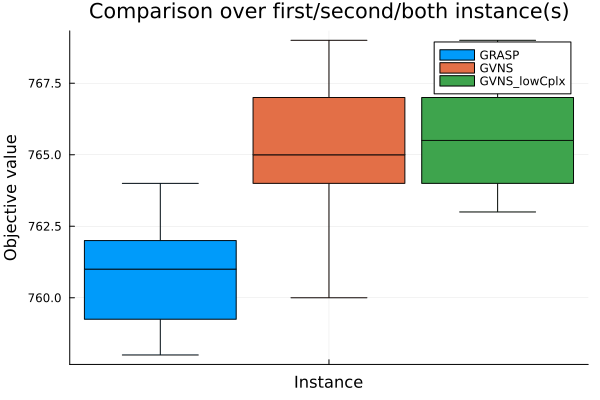

GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine INQ_TEXT
GKS: String is too long in routine TEXT
GKS: String is too long in routine INQ_TEXT


In [24]:
@df df groupedboxplot(:instance, :value, group = :algorithm,
                      xlabel="Instance", ylabel="Objective value",
                      legend = :topright, title = "Comparison over first/second/both instance(s)") # see above [1:1]